# Time Series Analysis of Earthquake Data

## Data Prep

In [1]:
import pandas as pd

df = pd.read_csv("data/earthquake_data_20251005_231758.csv")
df["datetime"] = pd.to_datetime(df["datetime"])

# Sort chronologically
df = df.sort_values("datetime")
df.set_index("datetime", inplace=True)

In [2]:
# Example: number of earthquakes per day
daily_counts = df["magnitude"].resample("D").count()

# Example: average daily magnitude
daily_magnitude = df["magnitude"].resample("D").mean()

## Earthquake Frequency & Magnitude over Time

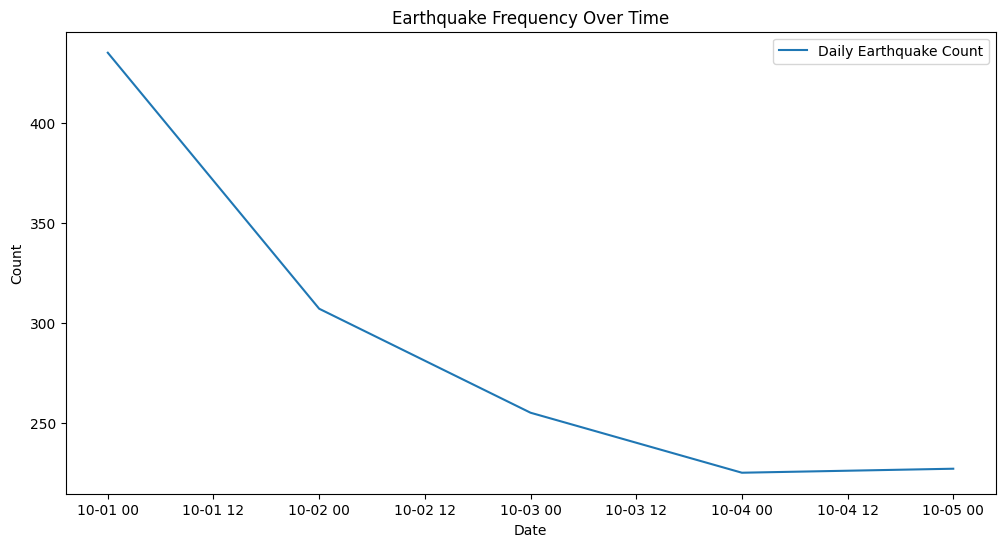

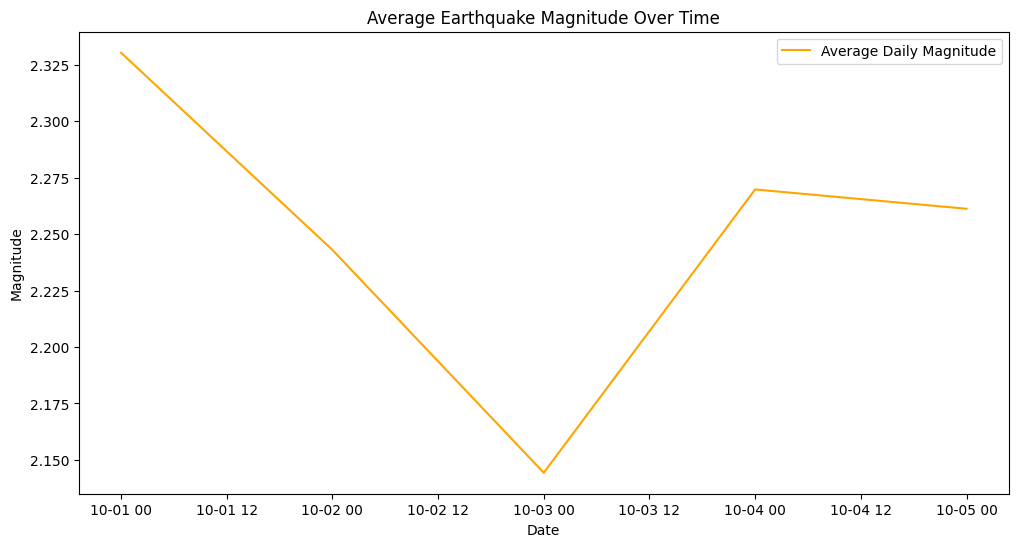

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_counts, label="Daily Earthquake Count")
plt.title("Earthquake Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(daily_magnitude, color="orange", label="Average Daily Magnitude")
plt.title("Average Earthquake Magnitude Over Time")
plt.xlabel("Date")
plt.ylabel("Magnitude")
plt.legend()
plt.show()


## Temporal Anomalies

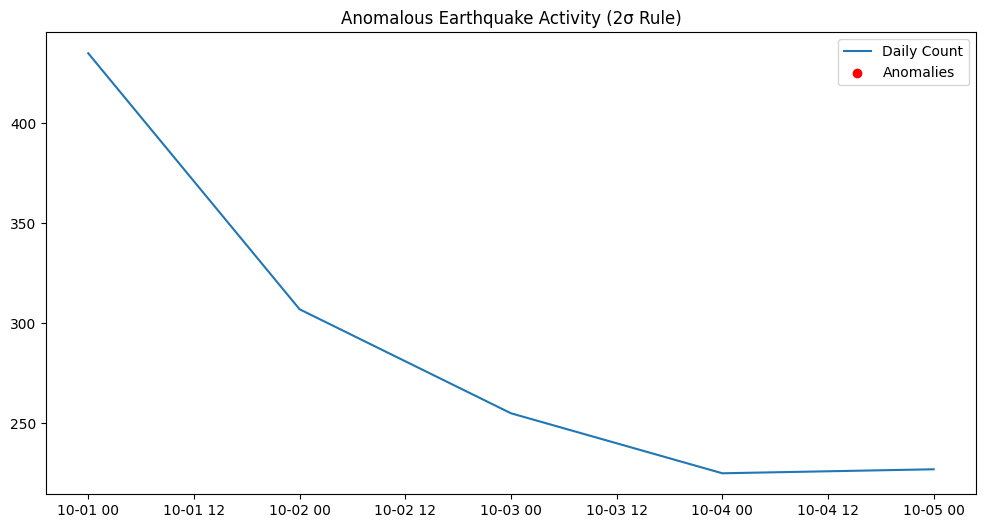

In [4]:
rolling_mean = daily_counts.rolling(window=7).mean()
rolling_std = daily_counts.rolling(window=7).std()

anomalies = daily_counts[(daily_counts - rolling_mean).abs() > 2 * rolling_std]

plt.figure(figsize=(12,6))
plt.plot(daily_counts, label="Daily Count")
plt.scatter(anomalies.index, anomalies.values, color="red", label="Anomalies")
plt.title("Anomalous Earthquake Activity (2σ Rule)")
plt.legend()
plt.show()


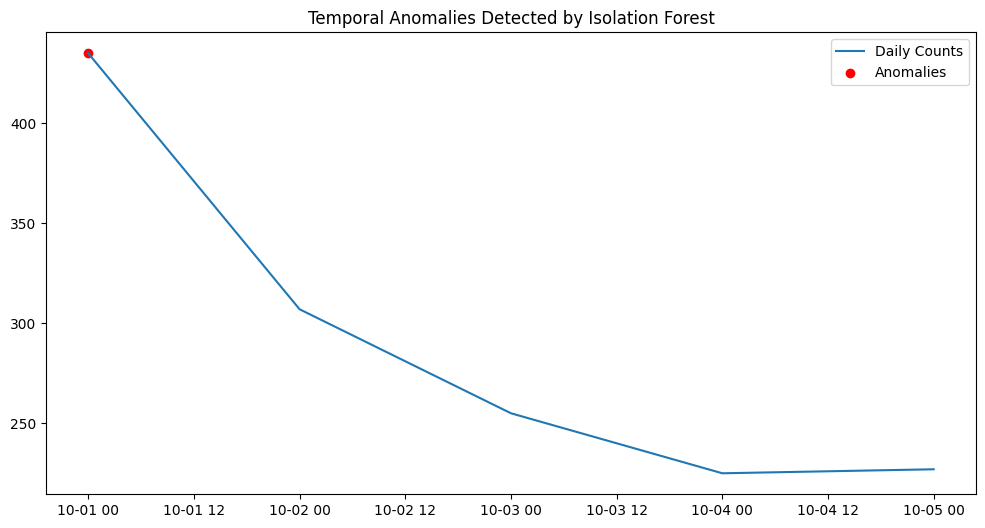

In [5]:
from sklearn.ensemble import IsolationForest
import numpy as np

values = daily_counts.fillna(0).values.reshape(-1, 1)
model = IsolationForest(contamination=0.05, random_state=42)
pred = model.fit_predict(values)

plt.figure(figsize=(12,6))
plt.plot(daily_counts.index, daily_counts.values, label="Daily Counts")
plt.scatter(daily_counts.index[pred == -1],
            daily_counts.values[pred == -1],
            color="red", label="Anomalies")
plt.title("Temporal Anomalies Detected by Isolation Forest")
plt.legend()
plt.show()


## Forecasting Earthquake Frequency

/Users/maxellmilay/.pyenv/versions/3.12.0/envs/earthquake-prediction/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/maxellmilay/.pyenv/versions/3.12.0/envs/earthquake-prediction/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


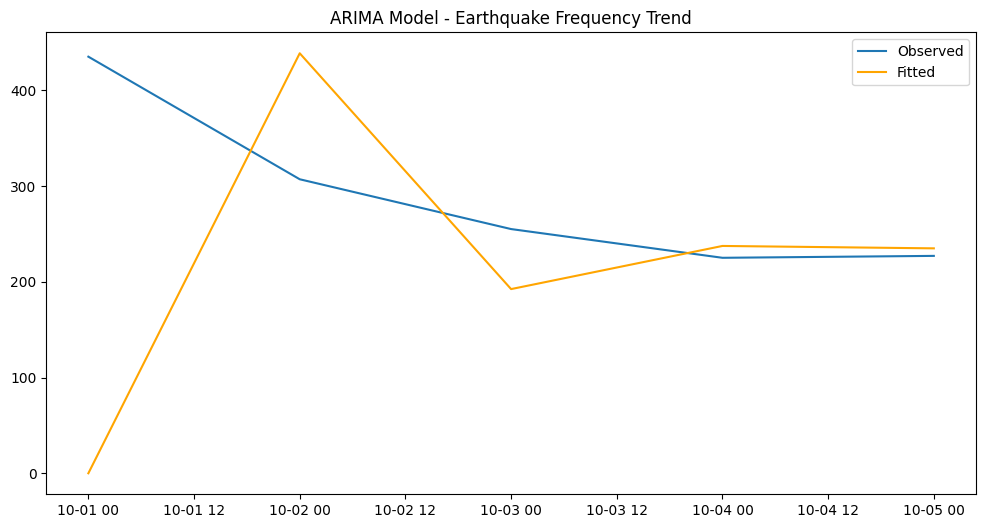

In [6]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(daily_counts.fillna(0), order=(2,1,2))
result = model.fit()

plt.figure(figsize=(12,6))
plt.plot(daily_counts, label="Observed")
plt.plot(result.fittedvalues, label="Fitted", color="orange")
plt.title("ARIMA Model - Earthquake Frequency Trend")
plt.legend()
plt.show()


/Users/maxellmilay/.pyenv/versions/3.12.0/envs/earthquake-prediction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
01:43:45 - cmdstanpy - INFO - Chain [1] start processing
01:43:46 - cmdstanpy - INFO - Chain [1] done processing


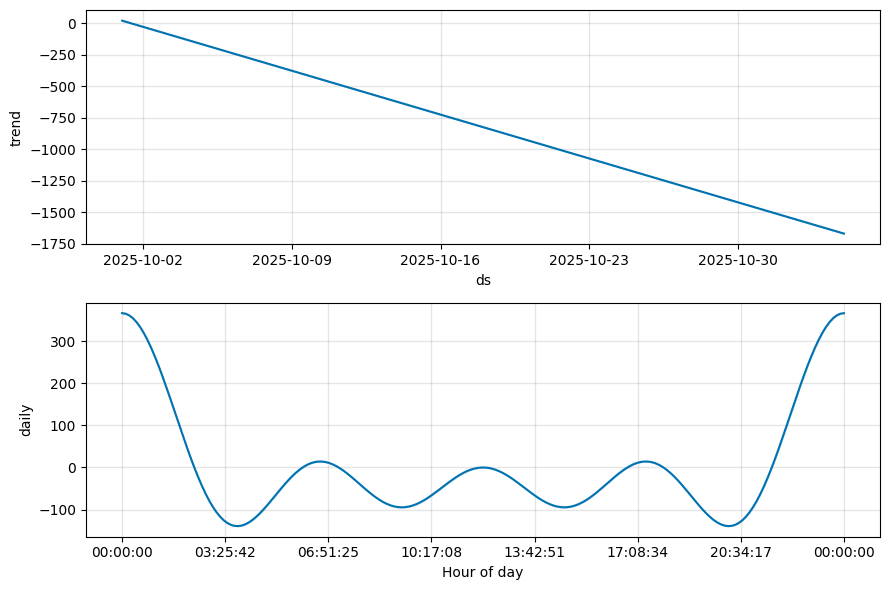

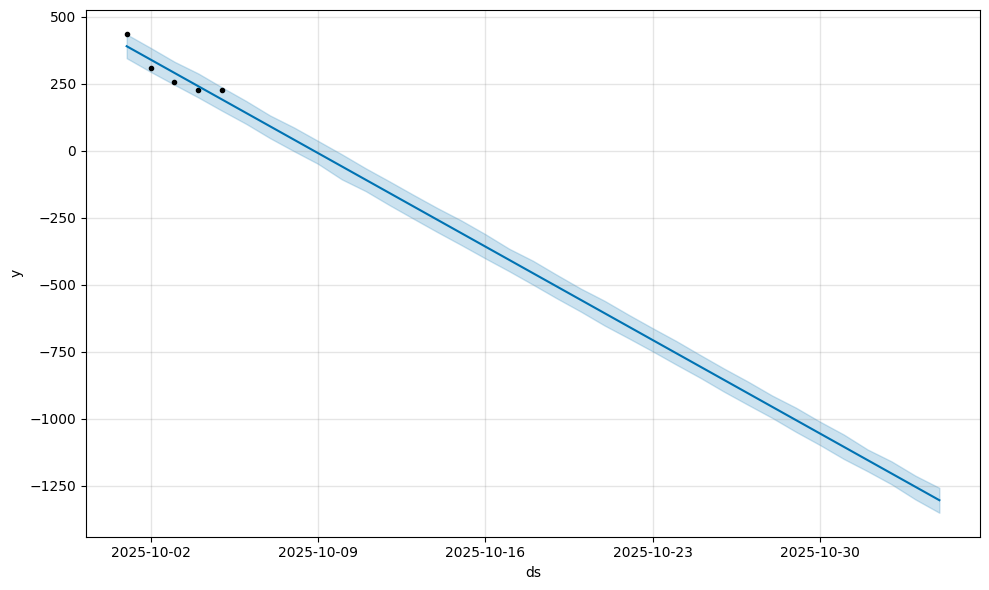

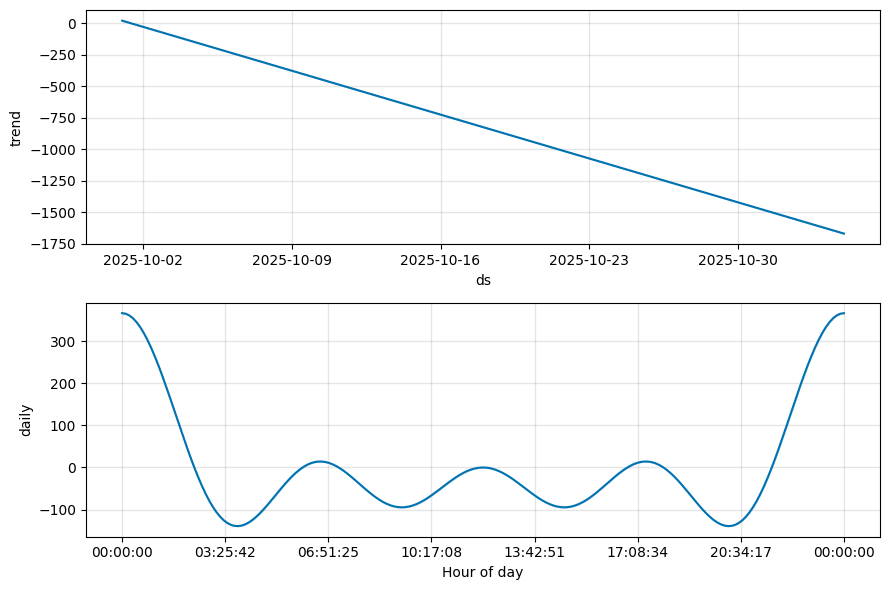

In [7]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = daily_counts.reset_index()
prophet_df.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
model.plot_components(forecast)
